In [223]:
import librosa, librosa.display
import numpy as np
import matplotlib.pyplot as plt
import os

In [224]:
def onestep_Harma(D, search_width=1):
    max_amp = np.max(D)             # finds the maximum amplitude in the amplitude spectrum D
    max_freq, max_t = np.unravel_index(np.argmax(D), D.shape) # finds the freq and t at which max_amp is attained

    freq_plot = [max_freq]          # initialise the frequency trajectory
    amp_plot = [D[max_freq, max_t]] # initialise the amplitude trajectory

    threshold_amp = (np.max(D) - np.min(D)) * .7    # set the amplitude threshold that marks the end of a syllable
    #threshold_dB = 20*np.log10(threshold_amp)       # convert the threshold to dB

    # Find the frequency at distance at most search_width away at the left time step that has the highest amplitude.
    def best_left(D,i,j):
        '''Returns where next we should go in frequency.'''    
        return np.argmax(D[i - search_width: i + search_width + 1 , j-1])

    # Get the leftwards frequency and amplitude plot
    i = max_freq
    j = max_t
    count = 0
    while D[i-search_width+best_left(D,i,j) , j-1] >= (max_amp - threshold_amp) and count < 1000 and i in range(D.shape[0]):
        i_new = i-search_width+best_left(D,i,j) 
        freq_plot = [i_new] + freq_plot
        amp_plot = [D[i_new, j-1]] + amp_plot
        i = i_new 
        j = j-1
        count += 1
    time_start = max_t - count

    # The same thing, but rightwards.
    def best_right(D,i,j):
        '''Returns where next we should go in frequency.'''    
        return np.argmax(D[i-search_width : i+search_width + 1 , j+1])

    i = max_freq
    j = max_t
    count = 0
    while D[i-search_width+best_right(D,i,j) , j+1] >= (max_amp - threshold_amp) and count < 1000 and i in range(D.shape[0]):
        i_new = i-search_width+best_right(D,i,j) 
        freq_plot = freq_plot + [i_new]  
        amp_plot = amp_plot + [D[i_new, j-1]]
        i = i_new 
        j = j+1
        count += 1
    time_end = max_t + count + 1

    return freq_plot, amp_plot, time_start, time_end



In [225]:
def Harma(D, search_width=1):
    Dc = D.copy()
    max_amp = np.max(D)

    freq_plots = []
    amp_plots = []

    threshold_amp = (np.max(D) - np.min(D)) * .35

    while np.max(Dc) >= max_amp - threshold_amp:
        freq_plot, amp_plot, time_start, time_end = onestep_Harma(Dc, search_width=search_width)
        freq_plots.append(freq_plot)
        amp_plots.append(amp_plot)
        Dc[:, time_start : time_end ] = 0.0
    
    return freq_plots, amp_plots, Dc
        

## Test


In [226]:
def load_song(filename):
    '''Load the sample audio file as a floating point time series.'''
    assert isinstance(filename, str)
    filename = 'Small_audio_sample/' + filename
    chirp_song, sr = librosa.load(filename) # chirp_song is the audio time series, sr is the sampling rate.
    return chirp_song, sr

def trim_freq(D, chop = 0.1):
    '''Takes a dB Mel spectrogram D, and trims off the chop-proportion of the lower frequencies; chop = 0.12 chops up until ~1.3kHz.
    Note: This modifies the np array D in place, so make a copy if you need the original.'''
    D[:int(chop*D.shape[0])] = np.ones((int(chop*D.shape[0]), D.shape[1])) * np.min(D)
    return D
    
def chop_stft(chirp_song, n_fft=2048, hop_length=128):
    '''Computes a short-time Fourier transform (stft) column matrix of everything after the first silence.
    chirp_song = time series of song
    sr = sample rate
    n_fft = FFT parameter'''

    split=librosa.effects.split(chirp_song, top_db=60)
    chirp_song_split=chirp_song[split[1,0]:
                                    #split[1,1]
                                    ]
    
    #Visualize the waveform as a function of time
    #librosa.display.waveshow(chirp_song, sr=sr);
    
    return librosa.stft(chirp_song_split, n_fft=n_fft,  hop_length=hop_length)

filename = '118960_mole.wav'
chirp_song, sr = load_song(filename)
D = np.abs(chop_stft(chirp_song, n_fft=2048, hop_length=64))
trim_freq(D, chop = 0.1)

array([[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       ...,
       [5.8701001e-08, 1.5461730e-07, 1.1386656e-07, ..., 4.6785111e-08,
        7.5772782e-08, 6.0105336e-08],
       [2.9525564e-08, 1.5200007e-07, 7.4910815e-08, ..., 3.0468460e-08,
        6.4639025e-08, 5.2975299e-08],
       [2.6718238e-08, 1.5287078e-07, 6.9857137e-08, ..., 1.0213382e-08,
        7.2534377e-08, 4.2204075e-08]], dtype=float32)

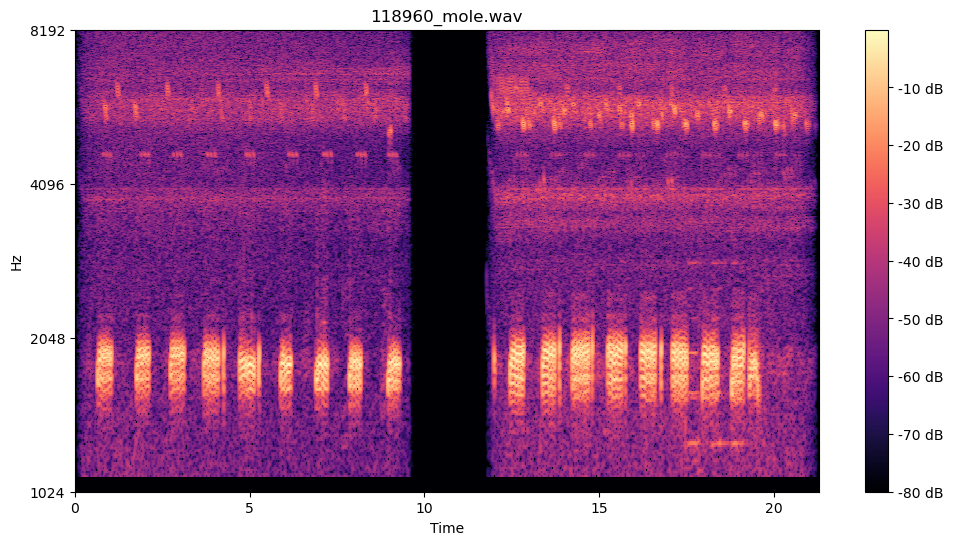

In [227]:
DB = librosa.amplitude_to_db(D, ref=np.max)

plt.figure(figsize=(12,6))
librosa.display.specshow(DB, sr=sr, hop_length=128, x_axis='time', y_axis='log');
plt.colorbar(format='%+2.0f dB');
plt.ylim(1024, 1024*8)
plt.title(str(filename))
plt.show()

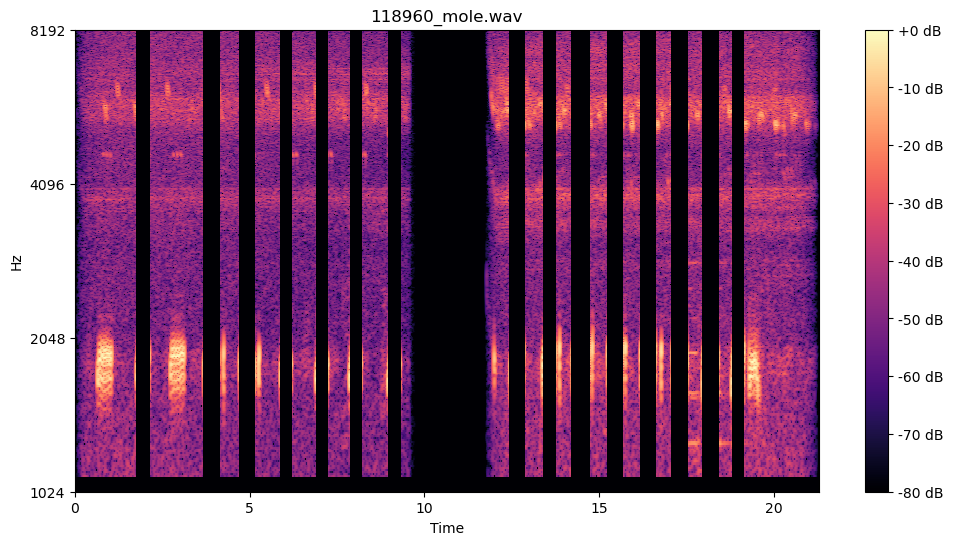

In [228]:
DB = librosa.amplitude_to_db(Harma(D)[2], ref=np.max)

plt.figure(figsize=(12,6))
librosa.display.specshow(DB, sr=sr, hop_length=128, x_axis='time', y_axis='log');
plt.colorbar(format='%+2.0f dB');
plt.ylim(1024, 1024*8)
plt.title(str(filename))
plt.show()